In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

from tqdm import tqdm

c:\ZUgantar\Projectsss\SHL\shlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
AUDIO_TRAIN_DATASET = "../Dataset/audios/train"
AUDIO_TEST_DATASET = "../Dataset/audios/test"
TRAIN_CSV = "../Dataset/train.csv"
TEST_CSV = "../Dataset/test.csv"
TRAIN_TEXT_CSV ="../train_text.csv" 
TEST_TEXT_CSV = "../test_text.csv"

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
train_df['relative_path'] = [f'{AUDIO_TRAIN_DATASET}/{name}' for name in train_df['filename']]
train_df

,filename,label,relative_path
0,audio_710.wav,1.0,../Dataset/audios/train/audio_710.wav
1,audio_1265.wav,1.0,../Dataset/audios/train/audio_1265.wav
2,audio_1114.wav,1.5,../Dataset/audios/train/audio_1114.wav
3,audio_946.wav,1.5,../Dataset/audios/train/audio_946.wav
4,audio_1127.wav,2.0,../Dataset/audios/train/audio_1127.wav
...,...,...,...
439,audio_613.wav,5.0,../Dataset/audios/train/audio_613.wav
440,audio_1002.wav,5.0,../Dataset/audios/train/audio_1002.wav
441,audio_1058.wav,5.0,../Dataset/audios/train/audio_1058.wav
442,audio_250.wav,5.0,../Dataset/audios/train/audio_250.wav


In [4]:
train_text_df = pd.read_csv(TRAIN_TEXT_CSV)
train_text_df = train_text_df.fillna('x')
train_df['text'] = train_text_df['sentence']
train_df

,filename,label,relative_path,text
0,audio_710.wav,1.0,../Dataset/audios/train/audio_710.wav,x
1,audio_1265.wav,1.0,../Dataset/audios/train/audio_1265.wav,my favorite hobby is cultivation of plants suc...
2,audio_1114.wav,1.5,../Dataset/audios/train/audio_1114.wav,my goal is to become an electrical employee an...
3,audio_946.wav,1.5,../Dataset/audios/train/audio_946.wav,the playground looks very clear and neat as th...
4,audio_1127.wav,2.0,../Dataset/audios/train/audio_1127.wav,my goal is to bring my parents to live with me...
...,...,...,...,...
439,audio_613.wav,5.0,../Dataset/audios/train/audio_613.wav,". . . . , she is in the hospital. she's in the..."
440,audio_1002.wav,5.0,../Dataset/audios/train/audio_1002.wav,"in a backdrop of a school, you might see bustl..."
441,audio_1058.wav,5.0,../Dataset/audios/train/audio_1058.wav,"my favourite place to visit is palm springs, c..."
442,audio_250.wav,5.0,../Dataset/audios/train/audio_250.wav,one of my favourite hobbies is to repurpose cl...


---

In [5]:
test_df = pd.read_csv(TEST_CSV)
test_df['relative_path'] = [f'{AUDIO_TEST_DATASET}/{path}' for path in test_df['filename']]
test_df

,filename,relative_path
0,audio_804.wav,../Dataset/audios/test/audio_804.wav
1,audio_1028.wav,../Dataset/audios/test/audio_1028.wav
2,audio_865.wav,../Dataset/audios/test/audio_865.wav
3,audio_774.wav,../Dataset/audios/test/audio_774.wav
4,audio_1138.wav,../Dataset/audios/test/audio_1138.wav
...,...,...
199,audio_787.wav,../Dataset/audios/test/audio_787.wav
200,audio_1079.wav,../Dataset/audios/test/audio_1079.wav
201,audio_550.wav,../Dataset/audios/test/audio_550.wav
202,audio_641.wav,../Dataset/audios/test/audio_641.wav


In [6]:
test_text_df = pd.read_csv(TEST_TEXT_CSV)
test_text_df = test_text_df.fillna('x')
test_df['text'] = test_text_df['sentence']
test_df

,filename,relative_path,text
0,audio_804.wav,../Dataset/audios/test/audio_804.wav,my hobbies are playing cricket because i am a ...
1,audio_1028.wav,../Dataset/audios/test/audio_1028.wav,my favorite place is in andhra pradesh. it is ...
2,audio_865.wav,../Dataset/audios/test/audio_865.wav,"yeah, my best today in my life is recently i g..."
3,audio_774.wav,../Dataset/audios/test/audio_774.wav,the most i use it to enjoy is practicing codin...
4,audio_1138.wav,../Dataset/audios/test/audio_1138.wav,i would to become a boutique engineer among th...
...,...,...,...
199,audio_787.wav,../Dataset/audios/test/audio_787.wav,my favorite hobby is betting on nba and footba...
200,audio_1079.wav,../Dataset/audios/test/audio_1079.wav,"my favorite place to travel is to ocean city, ..."
201,audio_550.wav,../Dataset/audios/test/audio_550.wav,this journey to switzerland is an adventure in...
202,audio_641.wav,../Dataset/audios/test/audio_641.wav,", my goal in life is to live a happy, fulfilli..."


---

features = [MFCCs + delta + delta-delta + spectral features + ZCR + RMS]

In [149]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
def AudioText(df, idx, model=sentence_model):
    audio_path = df.iloc[idx]['relative_path']

    y, sr = librosa.load(audio_path)

    # ----- Mel-Frequecny Cepstral Coefficient ----- 
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mean_mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=15), axis=1)
    delta_mfcc = np.mean(librosa.feature.delta(mfcc), axis=1)
    delta2_mfcc = np.mean(librosa.feature.delta(mfcc, order=2), axis=1)


    # ----- Spectral Features -----
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1)
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1)
    roll_off = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85), axis=1)
    
    # ----- ZCR -----
    zcr = np.mean(librosa.feature.zero_crossing_rate(y), axis=1)

    # ----- Root Mean Square Energy -----
    rms = np.mean(librosa.feature.rms(y=y), axis=1)

    text = df.iloc[idx]['text']
    embedding = model.encode(text)

    return np.concatenate([embedding, mean_mfcc, delta_mfcc, delta2_mfcc, centroid, rms]) 

---

In [150]:
combine_feature = []
combine_label = []
p_bar = tqdm(range(len(train_df)), ascii=" \/\/\/\/\/\/\/\/\|")
for idx in p_bar:
    combine_feature.append(AudioText(train_df, idx))
    combine_label.append(train_df.iloc[idx]['label'])

combine_feature = np.array(combine_feature)
combine_label = np.array(combine_label)

100%|||||||||||| 444/444 [05:09<00:00,  1.43it/s]


In [151]:
combine_feature_test = []

p_bar = tqdm(range(len(test_df)), ascii=" /\/\/\|")
for idx in p_bar:
    combine_feature_test.append(AudioText(test_df, idx))

combine_feature_test = np.array(combine_feature_test)

100%|||||||||||| 204/204 [02:04<00:00,  1.64it/s]


In [152]:
print(combine_feature.shape, combine_label.shape)

(444, 427) (444,)


---

In [153]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(combine_feature, combine_label, test_size=0.2, random_state=42)

In [154]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R2: {r2:.4f}")


RMSE: 1.0357
R2: 0.2075


MSE: 1.1525

1.0843

RMSE: 1.0735

1.0756

RMSE: 1.0420

RMSE: 1.0280


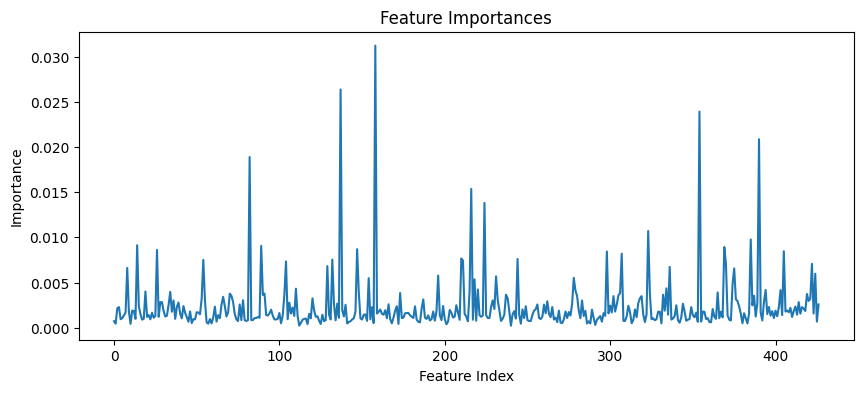

[0.00059436 0.00084632 0.00047901 0.00073926 0.00075172 0.00085301
 0.00065486 0.00079137 0.00065798 0.00088238 0.00085447 0.00042291
 0.00065324 0.00083198 0.0007146  0.00077168 0.00072164 0.00068875
 0.00083283 0.0008266  0.00054756 0.0009075  0.00065811 0.00052095
 0.00091641 0.0009009  0.00089523 0.00090732 0.00075196 0.00097911
 0.00054167 0.00107648 0.00058777 0.00053653 0.00060826 0.00091653
 0.00095306 0.00151783 0.00051304 0.00081798 0.00074322 0.00109296
 0.00101913 0.00084087 0.00102539 0.00089335 0.00084379 0.00073783
 0.00079554 0.00073917 0.00133261 0.00064539 0.00091774 0.00107847
 0.0004705  0.00087574 0.00079061 0.00078544 0.00134218 0.00096404
 0.00120294 0.00086266 0.00084827 0.00113795 0.00127933 0.00099957
 0.00093059 0.0008745  0.00137201 0.00102057 0.00086163 0.00073199
 0.00091111 0.00092702 0.0011647  0.000907   0.00069567 0.00107065
 0.0008122  0.00074368 0.00082531 0.00113059 0.00098716 0.00109774
 0.00080729 0.00106267 0.00111931 0.00083699 0.00089937 0.0011

In [155]:
import matplotlib.pyplot as plt

importance = model.feature_importances_

plt.figure(figsize=(10, 4))
plt.plot(importance)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()
print(importances)

In [156]:
top_indices = np.argsort(importance)[250:]
top_indices.shape


(177,)

In [157]:
x_train_reduced = x_train[:, top_indices]
x_test_reduced = x_test[:, top_indices]

In [158]:
model.fit(x_train_reduced, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

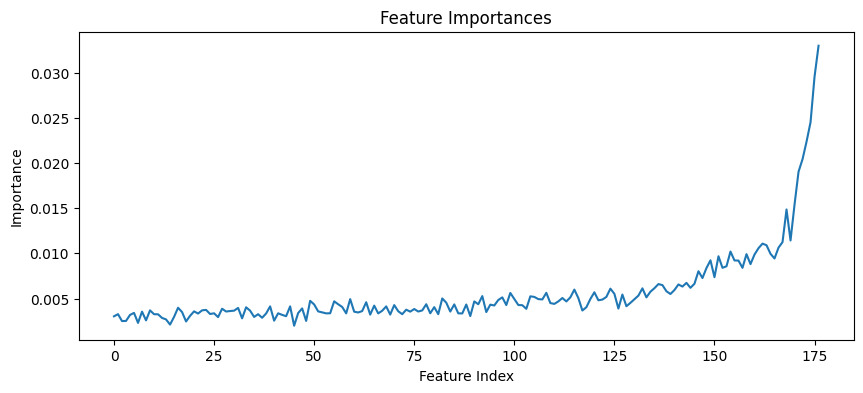

[0.00059436 0.00084632 0.00047901 0.00073926 0.00075172 0.00085301
 0.00065486 0.00079137 0.00065798 0.00088238 0.00085447 0.00042291
 0.00065324 0.00083198 0.0007146  0.00077168 0.00072164 0.00068875
 0.00083283 0.0008266  0.00054756 0.0009075  0.00065811 0.00052095
 0.00091641 0.0009009  0.00089523 0.00090732 0.00075196 0.00097911
 0.00054167 0.00107648 0.00058777 0.00053653 0.00060826 0.00091653
 0.00095306 0.00151783 0.00051304 0.00081798 0.00074322 0.00109296
 0.00101913 0.00084087 0.00102539 0.00089335 0.00084379 0.00073783
 0.00079554 0.00073917 0.00133261 0.00064539 0.00091774 0.00107847
 0.0004705  0.00087574 0.00079061 0.00078544 0.00134218 0.00096404
 0.00120294 0.00086266 0.00084827 0.00113795 0.00127933 0.00099957
 0.00093059 0.0008745  0.00137201 0.00102057 0.00086163 0.00073199
 0.00091111 0.00092702 0.0011647  0.000907   0.00069567 0.00107065
 0.0008122  0.00074368 0.00082531 0.00113059 0.00098716 0.00109774
 0.00080729 0.00106267 0.00111931 0.00083699 0.00089937 0.0011

In [159]:
importance = model.feature_importances_
plt.figure(figsize=(10, 4))
plt.plot(importance)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()
print(importances)

In [136]:
y_pred_reduced = model.predict(x_test_reduced)
mse = mean_squared_error(y_test, y_pred_reduced)
r2 = r2_score(y_test, y_pred_reduced)
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f'R2  : {r2}')

RMSE: 1.0359
R2  : 0.20719848792202955


In [67]:
combine_feature_test = combine_feature_test[:, top_indices]

In [68]:
pred = model.predict(combine_feature_test)
pred.shape

(204,)

In [ ]:
op = pd.DataFrame(columns=['filename', 'label'])
op['filename'] = test_df['filename']
op['label'] = np.round(pred, 2)
op.to_csv('ran_for.csv', index=False)